In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import Lasso

df_train = pd.read_csv('train.csv', header=None)
df_test = pd.read_csv('test.csv', header=None)
df_label = pd.read_csv('trainLabels.csv', header=None)
df_label.shape

(1000, 1)

In [2]:
# 擬合後, 將結果依照重要性由高到低排序
estimator = GradientBoostingClassifier()
MMEncoder = MinMaxScaler()
estimator.fit(df_train.values, df_label.values)

feats = pd.Series(data=estimator.feature_importances_, index=df_train.columns)
feats = feats.sort_values(ascending=False)
#print(feats)

# 取高重要性特徵
high_feature = list(feats[:14].index)
train_X = MMEncoder.fit_transform(df_train[high_feature])
cross_val_score(estimator, train_X, df_label, cv=5).mean()

D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

0.884

In [3]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, df_label, test_size=0.2, random_state=142)

# 建立模型
reg = GradientBoostingClassifier(random_state=142)

## 先看看使用預設參數得到的結果，約為 0.14 的 MSE
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print(metrics.mean_squared_error(y_test, y_pred))

D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.075


In [4]:
## Search for good hyperparameter values
# Specify values to grid search over
n_estimators = list(np.arange(1, 101, 10))
max_features = [None, 'sqrt', 'log2'] 
max_depth = list(np.arange(3, 11, 2))

hyperparameters = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth
    }
    
# Grid search using cross-validation
gridCV = GridSearchCV(GradientBoostingClassifier(random_state=142), param_grid=hyperparameters, cv=5, n_jobs=4)

# 開始搜尋最佳參數
grid_result = gridCV.fit(x_train, y_train)

# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


## 使用最佳參數重新建立模型
reg_bestparam = GradientBoostingClassifier(max_features=grid_result.best_params_['max_features'],
                                          n_estimators=grid_result.best_params_['n_estimators'],
                                          max_depth=grid_result.best_params_['max_depth'])

# 訓練模型
reg_bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = reg_bestparam.predict(x_test)

# 調整參數後約可降至 0.03 的 MSE
print(metrics.mean_squared_error(y_test, y_pred))

# Evaluation
auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Accuracy: 0.898750 using {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 81}


D:\Anaconda\envs\python3.6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.065
AUC:  0.935735101999799


In [11]:
submission = pd.DataFrame(reg_bestparam.predict(df_test[high_feature]), columns=['Solution'])
submission['Id'] = np.arange(1,submission.shape[0]+1)
submission = submission[['Id', 'Solution']]
submission

,Id,Solution
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0
5,6,0
6,7,0
7,8,1
8,9,0
9,10,0


In [12]:
submission.to_csv('submission.csv',index = False)

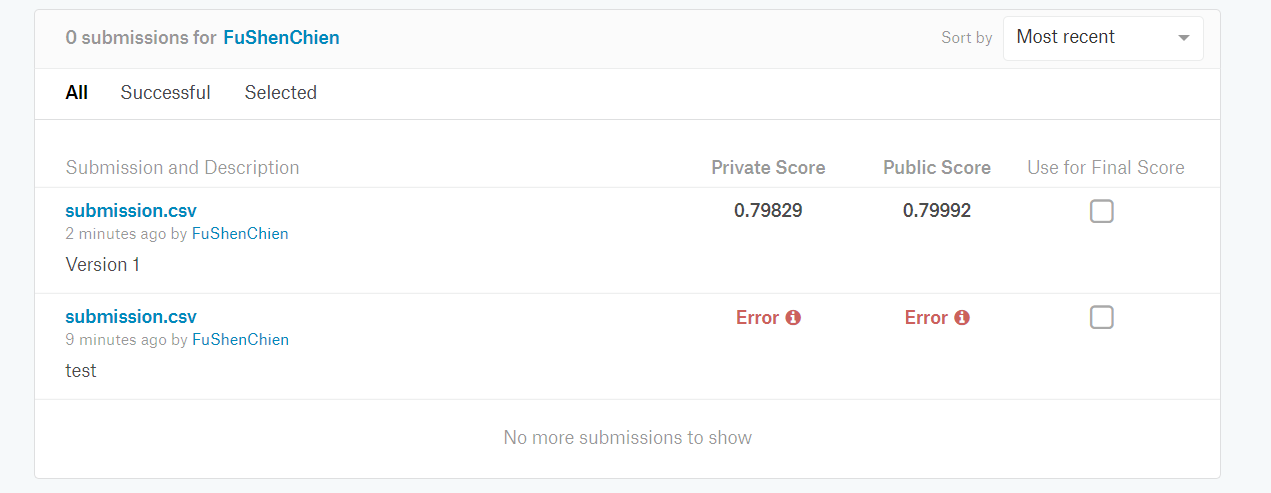